In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
cd drive/My Drive/kogaken/mlphase

/content/drive/My Drive/kogaken/mlphase


In [5]:
# coding: utf-8
# import subprocess

import sys
import os
import numpy as np
import json
import pickle
from datetime import datetime
# import itertools
import matplotlib.pyplot as plt
import random

# from making_2D_image_20191028 import load_data
# from making_2D_image_20191028 import surf_figure, reduce_pkl_data

# from common.simple_convnet import SimpleConvNet
# from common.trainer import Trainer
# from dataset.mnist import load_mnist
# import matplotlib as mpl

In [6]:
import tensorflow as tf

from tensorflow.python.keras.utils.vis_utils import plot_model

from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.callbacks import CSVLogger, EarlyStopping
# from keras.datasets import mnist
# from keras.layers import Activation, Dropout, Reshape, SeparableConv2D
# from keras.callbacks import EarlyStopping

# from file_operation import MAKE_DIR, COPY_FILES

# sys.path.append(os.pardir)

In [7]:
def make_fig_one_pair_abs(x, sfolder, text=""):
    temp1 = np.random.randint(0, np.shape(x[0])[0], size=4)

    n = len(x)
    print(np.shape(x[0]))
    fig = plt.figure()
    for i, j in enumerate(temp1):
        for k in range(n):
            ax = fig.add_subplot(4, n, (n * i) + k + 1)
            # ax.set_title("in")
            ax.set_xticks([], minor=False)
            ax.set_yticks([], minor=False)
            ax.imshow(np.abs(x[k][j, 0, :, :]))

    file = sfolder + "/" + "in_out_figs_" + text + "_".join(str(temp1)) + ".png"
    print(file)
    plt.savefig(file)
    plt.close()

In [8]:
def history_fig(history, file_train, sfolder):
    epochs = range(len(history.history['accuracy']))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='training')
    plt.plot(epochs, history.history['val_accuracy'], label='validation')
    plt.title('accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='training')
    plt.plot(epochs, history.history['val_loss'], label='validation')
    plt.title('loss')
    plt.ylim([0, 0.15])
    plt.legend()
    plt.savefig(sfolder + "/" + os.path.basename(file_train).split(".")[0] + '.png')


In [9]:
def save_model(model, file_train, sfolder):
    file = sfolder + "/" + "model_tree.png"
    print("save_file:", file)
    plot_model(model, to_file=file, show_shapes=True)
    # model.summary()

In [10]:
def reshape_complex(x, mode="abs_phase", normalize=True):

    if normalize:
        x = x / np.max(np.abs(x))

    if ("complex" in str(type(x[0, 0, 0, 0]))):
        if mode == "abs_phase":
            x = reshape_complex_to_abs_phase(x, axis=1)
            if normalize:
                x[:, 1, :, :] = (x[:, 1, :, :] + np.pi) / (2. * np.pi)
        if mode == "abs":
            x = np.abs(x)
        if mode == "real_imag":
            x = reshape_complex_to_real_imag(x, axis=1)
    return x


def reshape_complex_to_real_imag(x, axis=1):
    """RealとImag"""

    return np.append(np.real(x), np.imag(x), axis=axis)


def reshape_complex_to_abs_phase(x, axis=1):
    """絶対値と偏角"""

    return np.append(np.abs(x), np.angle(x), axis=axis)

In [11]:
def load_data(*files, num_data=0):
    if len(files) == 1:
        return load_data_1(files[0], num_data=num_data)
    elif len(files) == 2:
        return load_data_2(files[0], files[1], num_data=num_data)

In [12]:
def load_data_2(file1, file2, num_data=0):
    text = str(num_data)
    if num_data == 0:
        text = ""

    new_file = os.path.dirname(file1) + "/" \
        + os.path.basename(file1).split(".")[0] + "_" \
        + os.path.basename(file2).split(".")[0] + "_" \
        + text + ".pkl"

    if not os.path.isfile(new_file):
        print("make combined file: ", new_file)
        new_file = combine_pkl_data(file1, file2,
                                    new_file, num_data=num_data)

    print("load_data of input", file1, file2)
    print("load_data:", new_file)

    with open(new_file, "rb") as f:
        data = pickle.load(f)

    # z1, z2, t = [], [], []
    # ind = (np.random.permutation(len(data))[:num_data])

    # for i in ind:  # 2019.10.07 reducing data for memory flow
    #     row = data[i]
    #     z1.append([row["z1"]])
    #     z2.append([row["z2"]])
    #     t.append([row["m"], row["n"]])

    z1, z2, t = [], [], []

    for d in data:
        z1.append([d["z1"]])
        z2.append([d["z2"]])
        t.append([d["info"]])

    z1 = np.array(z1)
    z2 = np.array(z2)
    t = np.array(t)
    return (z1, z2, t)

In [13]:
def combine_pkl_data(file1, file2, new_file, num_data=0):

    with open(file1, "rb") as f:
        detec_data = pickle.load(f)
    with open(file2, "rb") as f:
        mirror_data = pickle.load(f)

    # if len(data1) != len(data2):
    #     print("error @ combine_pkl_data in maiking_2D_image_***")

    # if num_data == 0:
    #     num_data = len(data1)

    # ind = (np.random.permutation(len(data1))[:num_data])

    # data = []
    # for i in ind:  # 2019.10.07 reducing data for memory flow
    #     row1 = data1[i]
    #     row2 = data2[i]
    #     # print( i, row1["m"],row1["n"],row2["m"],row2["n"])
    #     row = {
    #         "m": row1["m"],
    #         "n": row1["n"],
    #         "z1": row1["z"],
    #         "z2": row2["z"]}
    #     data.append(row)

    i = 0
    data = []
    for e_data in mirror_data["elip"]:
        row = {
            "info": detec_data[i]["info"],
            "z1": detec_data[i]["z"],
            "z2": e_data["z"]
        }
        i += 1
        data.append(row)

    for m_data in mirror_data["mode"]:
        row = {
            "info": detec_data[i]["info"],
            "z1": detec_data[i]["z"],
            "z2": m_data["z"]
        }
        i += 1
        data.append(row)

    with open(new_file, 'wb') as f:
        pickle.dump(data, f)

    return new_file

In [35]:
def regressin_CNN(x, y, xt, yt, num_data, units, sfolder, epochs=100,
                  active_function="relu", num_conv_node="num_conv_node"):
    x = np.array(x)
    y = np.array(y)
    xt = np.array(xt)
    yt = np.array(yt)

    x = np.transpose(x, (0, 2, 3, 1))
    xt = np.transpose(xt, (0, 2, 3, 1))
    y = np.transpose(y, (0, 2, 3, 1))
    yt = np.transpose(yt, (0, 2, 3, 1))

    print("")
    print("check point 3")
    for s in [x, y, xt, yt]:
        print(np.shape(s))

    ydim = np.shape(y)
    out_dim = ydim[1] * ydim[2] * ydim[3]
    y = y.reshape(-1, out_dim)
    yt = yt.reshape(-1, out_dim)

    print("")
    print("check point 4")
    for s in [x, y, xt, yt]:
        print(np.shape(s))
        
    # active_func = active_function
    # "relu" # "tanh" # "linear" # "sigmoid" # # "relu", "sigmoid", "tanh",

    # ncn = num_conv_node

    model = Sequential()
    model.add(Input(shape=(16, 16, 2)))
    model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(126, (3, 3), activation="relu", padding="same"))
    
    model.add(Flatten())

    # model.add(Dense(50, activation="relu"))
    # model.add(Dense(50, activation="relu"))
    # model.add(Dense(50, activation="relu"))

    model.add(Dense(8064, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(8064, activation="relu"))
    model.add(Dropout(0.25))

    model.add(Dense(out_dim))

    model.compile(optimizer='rmsprop',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    history = model.fit(x=x,
                        y=y,
                        epochs=epochs,
                        validation_data=(xt, yt),
                        verbose=1,
                        callbacks=[EarlyStopping(patience=20, verbose=1)]
                        )
    y_pred = model.predict(xt)

    # print(history.history)

    file = "learning"
    history_fig(history, file, sfolder)
    # save_history(history, file, sfolder)
    save_model(model, file, sfolder)
    # save_components_fit(yt, y_pred, sfolder)
    # save_components_fit_9(yt, y_pred, sfolder)

    score = model.evaluate(x=xt, y=yt)
    err = np.sqrt(np.mean((yt - y_pred) ** 2))
    err2 = np.mean(np.sqrt((yt - y_pred) ** 2))
    print("  err :", err)
    print("  err2:", err2)
    print("scoore:", score)

    return (err, err2), score, y_pred

In [36]:
def main_regression_CNN_learn(file_x, file_y, file_test_x, file_test_y, sfolder, num_data=0,
                              active_function="relu", reshape_type="abs_phase", num_conv_node=50):
    x, y, _ = load_data(file_x, file_y, num_data=num_data)
    xt, yt, _ = load_data(file_test_x, file_test_y, num_data=100)

    print("")
    print("check point 1")
    for s in [x, y, xt, yt]:
        print(np.shape(s))

    x = reshape_complex(x, mode=reshape_type, normalize=True)
    y = reshape_complex(y, mode=reshape_type, normalize=True)
    xt = reshape_complex(xt, mode=reshape_type, normalize=True)
    yt = reshape_complex(yt, mode=reshape_type, normalize=True)

    print("")
    print("check point 2")
    for s in [x, y, xt, yt]:
        print(np.shape(s))

    units = [50, 50, 50]
    epochs = 100
    err, score, y_pred = regressin_CNN(x, y, xt, yt, num_data, units, sfolder,
                                       epochs=epochs,
                                       active_function=active_function,
                                       num_conv_node=num_conv_node)

    y_pred_2d = y_pred.reshape(-1, 1, np.shape(yt)[2], np.shape(yt)[3])

    for i in range(10):
        make_fig_one_pair_abs((xt, yt, y_pred_2d), sfolder, "pred")
    
    file = sfolder + "/output.json"
    with open(file, "w") as f:
        memo = {"sfolder": str(sfolder),
                "file_train_x": str(file_x),
                "file_train_y": str(file_y),
                "file_test_x": str(file_test_x),
                "file_test_y": str(file_test_y),
                "num_data": str(num_data),
                "num_unit": str(units),
                "epochs": str(epochs),
                "err": str(err),
                "test_loss": str(score[0]),
                "test_acc": str(score[1]),
                "active_func": str(active_function),
                "reshape_type": str(reshape_type),
                "num_conv_node": str(num_conv_node)
                }
        json.dump(memo, f, indent=4)

In [37]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [38]:
def main(data_folder, num_data, active_function="relu", sfolder="", reshape_type="abs_phase", num_conv_node=50):
    strtime = datetime.now().strftime("%Y%m%d%H%M" + "-" + "%S")
    print("")
    print("time=", strtime)

    # 保存フォルダの指定,時刻がフォルダの名前になる
    if not data_folder:
        os.makedirs(strtime)
        sfolder = strtime
    else:
        sfolder = data_folder + "/" + strtime
        os.makedirs(sfolder)

    file_train_y = data_folder + "/" + "mirror_train_data.pkl"
    file_train_x = data_folder + "/" + "detec_train_data.pkl"

    file_test_y = data_folder + "/" + "mirror_test_data.pkl"
    file_test_x = data_folder + "/" + "detec_test_data.pkl"

    # main_make_figs(file_train_x,file_train_y,sfolder,num_data=num_data)

    # main_learn(file_train_x,file_test,sfolder,num_data)
    
    # main_regression_learn(file_train_x,file_train_y,
    #                       file_test_x, file_test_y,
    #                       sfolder,num_data=num_data)

    seed_everything(43)

    main_regression_CNN_learn(file_train_x, file_train_y,
                              file_test_x, file_test_y, sfolder,
                              num_data=num_data,
                              active_function=active_function,
                              reshape_type=reshape_type,
                              num_conv_node=num_conv_node)


time= 202010151000-51
load_data of input result/2020_0925_164455_implement_gaussian/detec_train_data.pkl result/2020_0925_164455_implement_gaussian/mirror_train_data.pkl
load_data: result/2020_0925_164455_implement_gaussian/detec_train_data_mirror_train_data_5000.pkl
load_data of input result/2020_0925_164455_implement_gaussian/detec_test_data.pkl result/2020_0925_164455_implement_gaussian/mirror_test_data.pkl
load_data: result/2020_0925_164455_implement_gaussian/detec_test_data_mirror_test_data_100.pkl

check point 1
(5000, 1, 16, 16)
(5000, 1, 64, 64)
(100, 1, 16, 16)
(100, 1, 64, 64)

check point 2
(5000, 2, 16, 16)
(5000, 1, 64, 64)
(100, 2, 16, 16)
(100, 1, 64, 64)

check point 3
(5000, 16, 16, 2)
(5000, 64, 64, 1)
(100, 16, 16, 2)
(100, 64, 64, 1)

check point 4
(5000, 16, 16, 2)
(5000, 4096)
(100, 16, 16, 2)
(100, 4096)
Epoch 1/100
157/157 [==============================] - 4s 24ms/step - loss: 0.0632 - accuracy: 4.0000e-04 - val_loss: 0.0417 - val_accuracy: 0.0100
Epoch 2/100


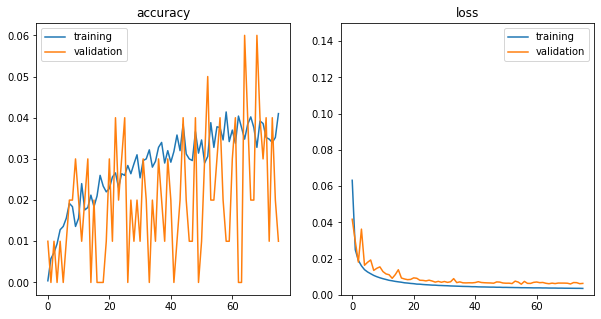

In [39]:
folder = "result/2020_0925_164455_implement_gaussian"
num_data = 5000
active_function="relu"

main(folder, num_data, active_function, sfolder='', reshape_type='real_imag')